In [227]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [228]:
# Reading Data 
filepath = 'data\original_data.csv'

og_data = pd.read_csv(filepath)
#og_data.head()

Text(0.5, 1.0, 'Pass Fail Distribution of Dataset')

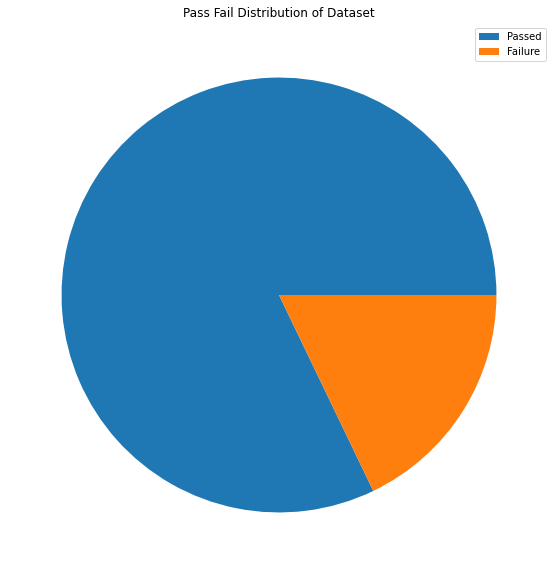

In [229]:
# Performing Initial EDA
og_data.dtypes.value_counts()
og_data.dtypes

fig = plt.figure(figsize=(10,10))
ax = plt.axes()

ax.pie(x=og_data['Pass'].value_counts())
labels = ['Passed','Failure']
ax.legend(labels)
ax.set_title('Pass Fail Distribution of Dataset')

Text(0.5, 1.0, 'Number of Previously Failed Classes vs Total Number of Fails')

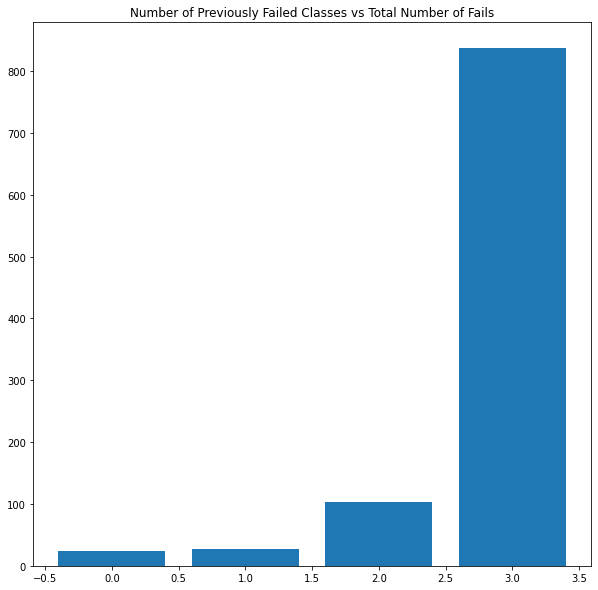

In [230]:
three_fails = pd.DataFrame(og_data[og_data['failures'] == 3]['Pass']).shape[0]
two_fails = pd.DataFrame(og_data[og_data['failures'] == 2]['Pass']).shape[0]
one_fails = pd.DataFrame(og_data[og_data['failures'] == 1]['Pass']).shape[0]
zero_fails = pd.DataFrame(og_data[og_data['failures'] == 0]['Pass']).shape[0]
y_axis = [three_fails, two_fails, one_fails, zero_fails]
x_axis = [0,1,2,3]

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.bar(x=x_axis,height=y_axis)
ax.set_title('Number of Previously Failed Classes vs Total Number of Fails')

<AxesSubplot:>

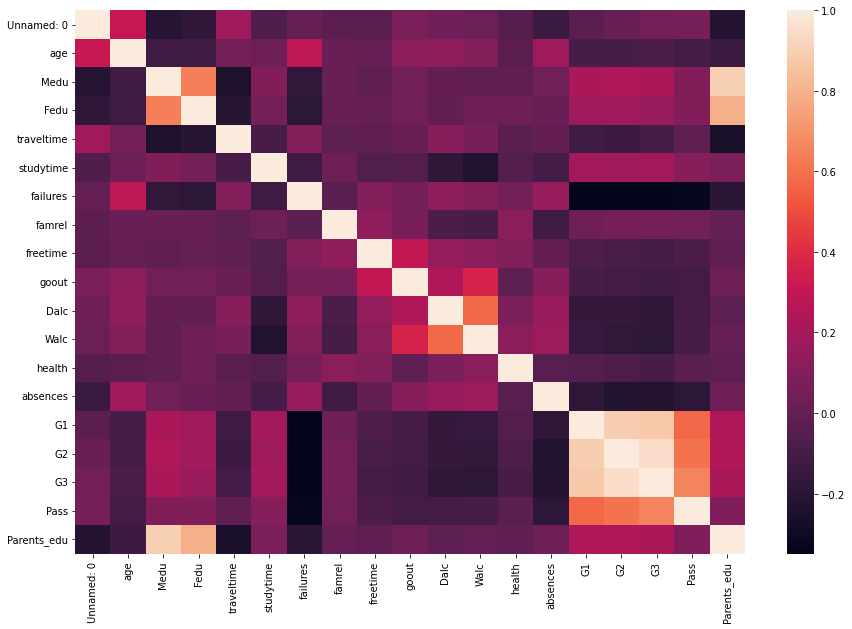

In [231]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(og_data.corr())

In [232]:
# It can be observed from the heatmap that "Pass" is positively correlated with each of the test scores("G1","G2","G3"); this makes intuitive sense. Its also observed that "Pass" is negatively correlated with "absences", "Walc(weekend alcohol consumption", "Dalc(weekday alcohol consumption", "freetime", "failures", and "age". All of these correlations make intuitive sense except the "age" correlation thus we will investigate that correlation further. 

Total Number of Students Age 22:  2
Total Number of Students Age 22 and Failed:  2


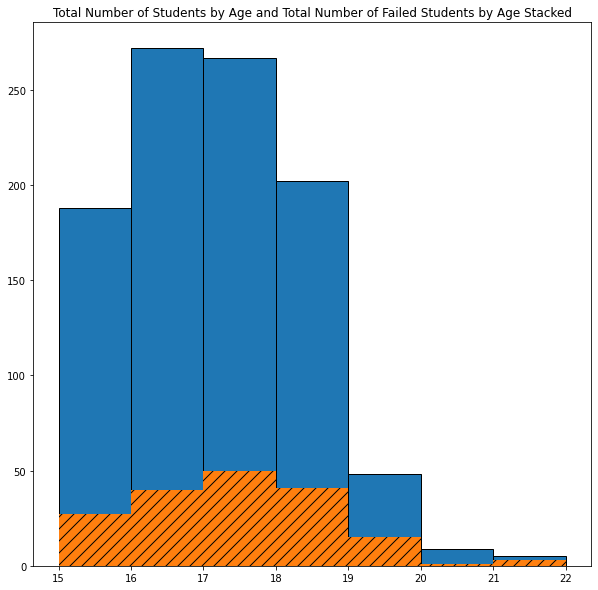

In [233]:
# Investigation into the correlation between age and pass
mybins = [15,16,17,18,19,20,21,22]
list = og_data['age']
list2 = og_data[og_data['Pass'] == False]['age']
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
_, bins, _ = ax.hist(list, bins=mybins, edgecolor='black', align='mid')
ax.hist(list2, bins=bins, hatch='//')
ax.set_title('Total Number of Students by Age and Total Number of Failed Students by Age Stacked')
print('Total Number of Students Age 22: ', og_data[(og_data['age'] == 22)]['age'].shape[0])
print('Total Number of Students Age 22 and Failed: ', og_data[(og_data['age'] == 22) & (og_data['Pass'] == False)].shape[0])

In [234]:
# By observation of the plot it can be seen that due to the low number of older student samples we have an unbalanced class. This is leading to a synthetic negative correlation between age and student pass rate thus the 'age' feature column will not be used in this analysis.
# To begin with I will use a simple model using only 'Pass', 'absences', 'Walc', 'Dalc', 'goout', 'freetime', 'failures', 'G1', 'G2', and 'G3'.

In [235]:
# Feature selection and cleaning
featureCols1 = ['absences', 'Fedu', 'Medu', 'Walc', 'Dalc', 'goout', 'freetime', 'failures', 'G1', 'G2', 'G3']
labelCol1 = ['Pass']
x_data1 = og_data[featureCols1]
y_data1 = og_data[labelCol1]

y_data1 = y_data1.replace(to_replace=[True, False], value=[1,0])

In [252]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(x_data1, y_data1))

X_train = x_data1.loc[train_idx,:]
y_train = y_data1.loc[train_idx,:]

X_test  = x_data1.loc[test_idx,:]
y_test  = y_data1.loc[test_idx,:]


In [268]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

In [253]:
# Standard logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [269]:
# The error on the training and test data sets
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

,train,test
accuracy,0.945166,0.959732
precision,0.941764,0.953307
recall,0.994728,1.000000
f1,0.967521,0.976096


In [270]:
# Decision Tree Model
### BEGIN SOLUTION
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)


### BEGIN SOLUTION
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

In [272]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(3, 1)

In [271]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)
train_test_gr_error


,train,test
accuracy,1.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1,1.0,1.0


In [275]:
dt.tree_.node_count, dt.tree_.max_depth

(3, 1)

In [280]:
list = og_data.dtypes == int 